In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import os
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import math
from math import sqrt

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization,ZeroPadding2D, Add
from keras.optimizers import Adam
from keras import backend as K
from keras.datasets import cifar10
from keras.layers import Input,Activation
from keras.models import Model

import tensorflow as tf
from tensorflow.keras import initializers, regularizers
from keras.regularizers import l2
from keras.initializers import glorot_uniform

Using TensorFlow backend.


In [2]:
labels_df = pd.read_csv('labels.csv')

#creating a column 'Id' and filling the values with the position with respect to the dataframe
y_cols = ['top','mid_L_top','mid_R_top','mid_L_bot','mid_R_bot','bot_L','bot_R']

labels_df['Id'] = range(1,len(labels_df)+1)
#converting strings to lists
from ast import literal_eval
for columns in labels_df[y_cols]:
    for i in range(len(labels_df)):
        labels_df[columns][i] = literal_eval(labels_df[columns][i])

/home/aleti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [3]:
#train and test splittitng
y_cols = ['top','mid_L_top','mid_R_top','mid_L_bot','mid_R_bot','bot_L','bot_R']
Y_train_df,Y_test_df = train_test_split(labels_df,test_size = 0.2,random_state=0)
labels_df.head()

,Unnamed: 0,Unnamed: 1,top,mid_L_top,mid_R_top,mid_L_bot,mid_R_bot,bot_L,bot_R,\n,Id
0,vid_37_frame_400_3.jpg,NaN,"[14, 1]","[7, 14]","[19, 15]","[5, 22]","[19, 23]","[2, 33]","[21, 35]",NaN,1
1,vid_37_frame_346_0.jpg,NaN,"[19, 4]","[12, 20]","[26, 20]","[10, 35]","[28, 35]","[7, 50]","[32, 50]",NaN,2
2,vid_37_frame_208_3.jpg,NaN,"[16, 1]","[9, 14]","[20, 13]","[8, 22]","[21, 22]","[4, 34]","[22, 35]",NaN,3
3,vid_36_frame_54_5.jpg,NaN,"[11, 0]","[7, 8]","[15, 8]","[6, 14]","[15, 14]","[4, 20]","[16, 21]",NaN,4
4,vid_37_frame_204_4.jpg,NaN,"[12, 0]","[6, 15]","[17, 15]","[4, 28]","[19, 28]","[2, 44]","[24, 43]",NaN,5


In [574]:
#loading images and their original resolution
# opencv reads images in BRG format but matplotlib reads it in RBG. So the image format is converted accordingly for matplotlib
def load_images(folder):
    images_train = []
    images_test = []
    i=0
    original_res_train = []
    original_res_test = []
    for filename in Y_train_df['Unnamed: 0']:
        img = cv2.imread(os.path.join(folder,str(filename)))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        if img is not None:
            images_train.append(img)
            original_res_train.append(list(img.shape))
    for filename in Y_test_df['Unnamed: 0']:
        img = cv2.imread(os.path.join(folder,str(filename)))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        if img is not None:
            images_test.append(img)
            original_res_test.append(list(img.shape))

            
            
    return images_train,images_test,original_res_train,original_res_test

In [575]:
path = '/home/aleti/Desktop/key_point_cone/RektNet_Dataset'

In [576]:
imgs_train,imgs_test,original_res_train,original_res_test = load_images(path)
imgs_train = np.array(imgs_train)
imgs_test = np.array(imgs_test)

In [577]:
# The co-ordinates for each example are converted into arrays of shape(1,14)
def create_labels_array():
    k = []
    labels_k_train = []
    labels_k_test = []
    for i in Y_train_df['Id']:
        k = []
        for j in Y_train_df[y_cols]:
            k.append(Y_train_df[j][i-1])
        k = np.array(k)
        k = k.reshape(1,14)
        labels_k_train.append(k)
        
    for i in Y_test_df['Id']:
        k = []
        for j in Y_test_df[y_cols]:
            k.append(Y_test_df[j][i-1])
        k = np.array(k)
        k = k.reshape(1,14)
        labels_k_test.append(k)
            

    labels_k_train = np.array(labels_k_train)
    Y_train_lables = labels_k_train.reshape(len(Y_train_df),14)
    
    labels_k_test = np.array(labels_k_test)
    Y_test_labels = labels_k_test.reshape(len(Y_test_df),14)
    
    return Y_train_lables,Y_test_labels

In [578]:
Y_train,Y_test = create_labels_array()
print(Y_train.shape)
print(Y_test.shape)
print(imgs_test[5].shape)
original_res_test[5]

(2557, 14)
(640, 14)
(29, 18, 3)


[29, 18, 3]

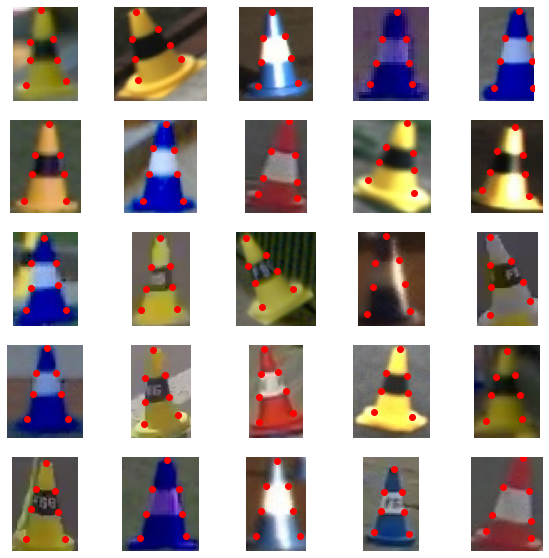

In [579]:
plt.figure(figsize =(10,10))
for n in range(25):
    ax = plt.subplot(5,5,n+1)
    points = Y_train[n].reshape(7,2)
    plt.plot(points[:,0],points[:,1],'ro')
    plt.imshow(imgs_train[n])
    plt.axis('off')

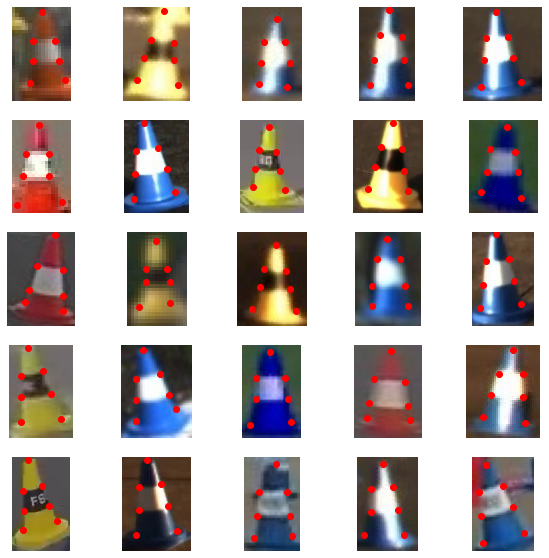

In [580]:
plt.figure(figsize =(10,10))
for n in range(25):
    ax = plt.subplot(5,5,n+1)
    points = Y_test[n].reshape(7,2)
    plt.plot(points[:,0],points[:,1],'ro')
    plt.imshow(imgs_test[n])
    plt.axis('off')

In [581]:
def rescale(img_train,img_test,Y_train,orig_train,Y_test,orig_test,new_img_size):
    
    train = []
    X_train_imgs = np.empty([len(img_train),new_img_size,new_img_size,3])
    for i in range(len(Y_train)):
        img_train[i] = cv2.resize(img_train[i],dsize=(new_img_size,new_img_size),interpolation = cv2.INTER_CUBIC)
        train.append(img_train)
        orig_train_x = orig_train[i][0]
        orig_train_y = orig_train[i][1]
        
        scale_y = new_img_size/orig_train_y
        scale_x = new_img_size/orig_train_x
        
        train_example = Y_train[i].reshape(7,2)
        train_example[:,0] = train_example[:,0]*scale_y
        train_example[:,1] = train_example[:,1]*scale_x
        train_example = train_example.reshape(1,14)
        Y_train[i] = train_example
        
        X_train_imgs[i] = img_train[i]
    
    X_test_imgs = np.empty([len(img_test),new_img_size,new_img_size,3])
    for i in range(len(Y_test)):
        
        img_test[i] = cv2.resize(img_test[i],dsize=(new_img_size,new_img_size),interpolation = cv2.INTER_CUBIC)
        orig_test_x = orig_test[i][0]
        orig_test_y = orig_test[i][1]
        
        scale_test_x = new_img_size/orig_test_x
        scale_test_y = new_img_size/orig_test_y

        test_example = Y_test[i].reshape(7,2)
        test_example[:,0] = test_example[:,0]*scale_test_y
        test_example[:,1] = test_example[:,1]*scale_test_x
        test_example = test_example.reshape(1,14)
        Y_test[i] = test_example
        
        X_test_imgs[i] = img_test[i]
        
    return X_train_imgs, X_test_imgs, Y_train,Y_test

In [582]:
X_train_imgs,X_test_imgs,Y_train,Y_test = rescale(imgs_train,imgs_test,Y_train,original_res_train,Y_test,original_res_test,80)

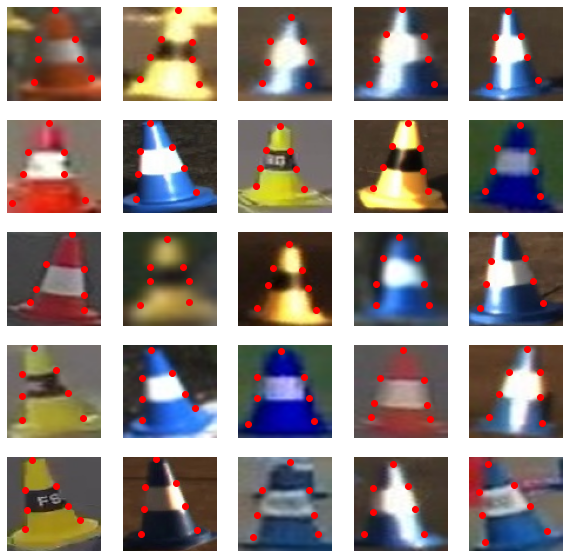

In [583]:
plt.figure(figsize =(10,10))
for n in range(25):
    ax = plt.subplot(5,5,n+1)
    points = Y_test[n].reshape(7,2)
    plt.plot(points[:,0],points[:,1],'ro')
    plt.imshow(X_test_imgs[n].astype(np.uint8))
    plt.axis('off')

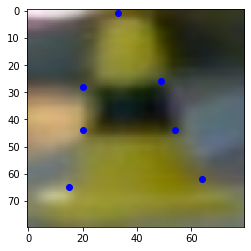

In [584]:
plt.imshow(X_train_imgs[0]/255)
keys = Y_train[0].reshape(7,2)
plt.plot(keys[:,0],keys[:,1],'bo')
plt.imshow(X_train_imgs[0].astype(np.uint8),vmin =0,vmax =1)

In [585]:
X_train = X_train_imgs/255
X_test = X_test_imgs/255
print("X_train_shape :",X_train.shape)
print("X_test_shape : ",X_test.shape)
print("Y_train_shape :", Y_train.shape)
print("Y_test_shape :",Y_test.shape)
print(Y_train[0].reshape(7,2))
global i
i = 0
N = tf.Variable(5)

X_train_shape : (2557, 80, 80, 3)
X_test_shape :  (640, 80, 80, 3)
Y_train_shape : (2557, 14)
Y_test_shape : (640, 14)
[[33  1]
 [20 28]
 [49 26]
 [20 44]
 [54 44]
 [15 65]
 [64 62]]


In [586]:
def cross_ratio_loss(Y,Y_hat):
    
    #Y should be of shape[batch_size,14]
    
    
    Y = tf.reshape(Y,[1,7,2])
    Y_hat = tf.reshape(Y_hat,[1,7,2])

    total_loss = 0
    sum1 = K.sum(K.square(Y-Y_hat))
    sum2 = K.sum(K.square(Y-Y_hat))
    
    total_loss = sum1 + sum2 
    
    #looping over all individual batches 
    for k in range(1):
        loss = 0
        
        points_Y_left = []
        points_Y_hat_left = []

        points_Y_right = []
        points_Y_hat_right = []

        points_Y_left.append(Y[k,0,:])
        points_Y_right.append(Y[k,0,:])
        points_Y_hat_left.append(Y_hat[k,0,:])
        points_Y_hat_right.append(Y_hat[k,0,:])
        for i in range(1,7):
            if i%2 == 0:
                points_Y_hat_right.append(Y_hat[k,i,:])
                points_Y_right.append(Y[k,i,:])
            if i%2 != 0:
                points_Y_hat_left.append(Y_hat[k,i,:])
                points_Y_left.append(Y[k,i,:])

        #sum1 = K.sum(K.square(Y[k,:,0]-Y_hat[k,:,0]))
        #sum2 = K.sum(K.square(Y[k,:,1]-Y_hat[k,:,1]))
        
        Cr_left_3D = cross_ratio(points_Y_left)
        Cr_right_3D = cross_ratio(points_Y_right)
        Cr_left_2D = cross_ratio(points_Y_hat_left)
        Cr_right_2D = cross_ratio(points_Y_hat_right)
        
        
        loss = (((Cr_left_3D - Cr_left_2D)**2) + ((Cr_right_3D - Cr_right_2D)**2))
        total_loss +=  loss
    return total_loss
    

In [587]:
    
       # batches = tf.compat.v1.placeholder(tf.float32, [None, None])

In [588]:
def distances(a,b,c,d):
    return K.sqrt((K.square(a-b)) + (K.square(c-d)))

In [589]:
def custom_cross(Y,Y_hat):
    
    sum1 = K.sum(K.square(Y-Y_hat))
    total_loss = sum1
    
    for i in range(1):
        ratio_left_3D = ratio_left(Y[i])
        ratio_right_3D = ratio_right(Y[i])
        ratio_left_2D = ratio_left(Y_hat[i])
        ratio_right_2D = ratio_right(Y_hat[i])

        l1 = K.square(ratio_left_3D - ratio_left_2D)
        l2 = K.square(ratio_right_3D - ratio_right_2D)

        total_loss = total_loss + 0.0001*l1 + 0.0001*l2
            
        
    

    return total_loss

In [590]:
def ratio_left(A):
    
    delta_13 = distances(A[0],A[6],A[1],A[7])
    delta_14 = distances(A[0],A[10],A[1],A[11])
    delta_23 = distances(A[2],A[6],A[3],A[7])
    delta_24 = distances(A[2],A[10],A[3],A[11])
    
    return (delta_13/delta_14)/(delta_23/delta_24)

In [591]:
def ratio_right(A):
    
    delta_15 = distances(A[0],A[8],A[1],A[9])
    delta_16 = distances(A[0],A[12],A[1],A[13])
    delta_56 = distances(A[4],A[8],A[5],A[9])
    delta_57 = distances(A[4],A[12],A[5],A[13])
    
    return (delta_15/delta_16)/(delta_56/delta_57)

In [592]:
def cross_ratio(C):
    
    # C is a list of 4 points. Indexing from 0
    
    delta_02 = K.sqrt((C[0][0] - C[2][0])**2 + (C[0][1] - C[2][1])**2)
    delta_03 = K.sqrt((C[0][0] - C[3][0])**2 + (C[0][1] - C[3][1])**2)
    
    delta_12 = K.sqrt((C[1][0] - C[2][0])**2 + (C[1][1] - C[2][1])**2)
    delta_13 = K.sqrt((C[1][0] - C[3][0])**2 + (C[1][1] - C[3][1])**2)
    
    return (delta_02/delta_03)*(delta_12/delta_13)
    

In [601]:
def resnet(X,output_channels):
    
    padding_1 = ZeroPadding2D((2,2))
    conv1 = Conv2D(output_channels, (3,3) ,strides = (1,1),padding = 'valid', dilation_rate = 2)
    bn1 = BatchNormalization(axis = 3)
    relu1 = Activation('relu')
    
    padding_2 = ZeroPadding2D((1,1))
    conv2 = Conv2D(output_channels, (3,3) , strides = (1,1),padding = 'valid')
    bn2 = BatchNormalization(axis = 3)
    relu2 = Activation('relu')
    
    short_cut_conv = Conv2D(output_channels, (1,1), strides = (1,1))
    short_cut_bn = BatchNormalization(axis = 3)
    
    p1 = padding_1(X)
    c1 = conv1(p1)
    b1 = bn1(c1)
    act1 = relu1(b1)
    
    p2 = padding_2(act1)
    c2 = conv2(p2)
    b2 = bn2(c2)
    act2 = relu2(b2)
    
    short_cut = short_cut_conv(X)
    s_c = short_cut_bn(short_cut)
    
    X = Add()([act2,s_c])
    
    return X

In [610]:
def resnet_model(input_shape):
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((3,3))(X_input)
    X = Conv2D(16, (7,7), strides = (1,1), padding = 'valid')(X)
    
    X = resnet(X,16)
    X = resnet(X,16*2)
    X = resnet(X,16*4)
    X = resnet(X,16*8)
    
    X = Conv2D(14, (1,1), strides =(1,1),padding = 'valid')(X)
    
    X = Flatten()(X)
    X = Dense(14,activation='softmax')(X)
    
    model = Model(inputs = X_input,outputs = X, name = 'resnet')
    
    return model
    
    

In [611]:
def model(input_shape):
    X_input = Input(input_shape)
    
    X = Conv2D(64,(3,3),strides =(2,2),padding = 'valid',name= 'conv1',kernel_regularizer = l2(0.01))(X_input)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), name = 'maxpool')(X)
    
    X = resnet(X,64)
    
    X = Conv2D(64,(3,3),strides = (2,2), padding = 'valid',name = 'conv2')(X)
    X = BatchNormalization(axis = 3,name = 'bn2')(X)
    X = Activation('relu')(X)
    
    #X_shortcut_1 = X
    #X = Conv2D(64,(1,1),strides =(1,1),name ='conv3',kernel_regularizer = l2(0.01))(X)
    #X = BatchNormalization(axis = 3, name = 'bn3')(X)
    #X = Add()([X_shortcut_1,X])
    #X = Activation('relu')(X)
    
   # X = Conv2D(128,(3,3),strides = (2,2),name = 'con4',kernel_regularizer = l2(0.01))(X)
   # X = BatchNormalization(axis = 3,name = 'bn4')(X)
   # X = Activation('relu')(X)
    
   # X_shortcut_2 = X
    
   # X = Conv2D(128,(1,1),strides = (1,1),name = 'conv5')(X)
   # X = BatchNormalization(axis = 3,name = 'bn5')(X)
   # X = Add()([X_shortcut_2,X])
   # X = Activation('relu')(X)
    
    X = Conv2D(128,(3,3),strides = (2,2), padding = 'valid',name = 'conv3',kernel_regularizer = l2(0.01))(X)
    X = BatchNormalization(axis = 3,name = 'bn3')(X)
    X = Activation('relu')(X)
    
       
    X = Conv2D(256,(3,3),strides = (2,2), padding = 'valid',name = 'conv4',kernel_regularizer = l2(0.01))(X)
    X = BatchNormalization(axis = 3,name = 'bn4')(X)
    X = Activation('relu')(X)
 
    
    
    X = Flatten()(X)
    #X = Dropout(0.2)(X)
    #X = Dense(256,activation = 'relu', name = 'fc')(X)
    X = Dropout(0.2)(X)
    X = Dense(128,activation ='relu',name = 'fc-2')(X)
    #X = Dropout(0.2)(X)
    #X = Dense(64,activation ='relu',name = 'fc-3')(X)
    X = Dropout(0.2)(X)
    X = Dense(14,activation = 'softmax',name = 'fc-layer')(X)
    
    model = Model(inputs = X_input,outputs = X,name = 'trial')
    return model

In [612]:
def trial_model(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2,2))(X_input)
    X = Conv2D(16,(5,5),strides =(1,1),padding = 'valid',dilation_rate = 2)(X)
    
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(16,(3,3),strides = (1,1),padding = 'valid')(X)
    
    #X = Conv2D(16,(3,3),strides = (1,1),padding = 'valid')(X)
    model = Model(inputs = X_input, outputs = X, name = 'trial-2')
    return model

In [613]:
def trial_model2(input_shape):
    X_input = Input(input_shape)
   #X = ZeroPadding2D((2,2))(X_input)
    X = Conv2D(16,(5,5),strides =(1,1),padding = 'valid',dilation_rate = 4)(X_input)

    model = Model(inputs = X_input, outputs = X, name = 'trial-2')
    return model

In [614]:
input_shape = (20,20,3)
trial = trial_model2(input_shape)
trial.summary()

Model: "trial-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_108 (InputLayer)       (None, 20, 20, 3)         0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 4, 4, 16)          1216      
Total params: 1,216
Trainable params: 1,216
Non-trainable params: 0
_________________________________________________________________


In [616]:
input_shape = (80,80,3)
model = resnet_model(input_shape)

In [617]:
adam = tf.keras.optimizers.Adam(lr = 0.00001)
model.compile(optimizer = adam, loss = custom_cross, metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train,Y_train,epochs = 30,batch_size = 16)

Epoch 1/30
 160/2557 [>.............................] - ETA: 30:46 - loss: 413888.5531 - accuracy: 0.1000

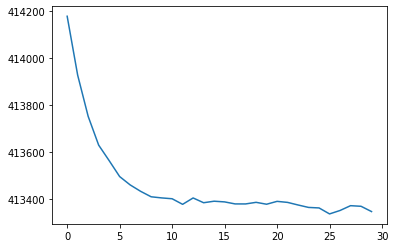

In [609]:
plt.plot(history.history['loss'])

In [364]:
# the below code isnt part of the main part
    def loss(Y,Y_hat):
    
    num = tf.shape(Y[0].eval())
    
    for i in range(num):
        
        ratio_left_3D = ratio_left(Y[i])
        ratio_right_3D = ratio_right(Y[i])
        ratio_left_2D = ratio_left(Y_hat[i])
        ratio_right_2D = ratio_right(Y_hat[i])

        l1 = K.square(ratio_left_3D - ratio_left_2D)
        l2 = K.square(ratio_right_3D - ratio_right_2D)

        total_loss = total_loss + 0.0001*l1 + 0.0001*l2

    return total_loss

In [365]:
# debug part _ not main code


var_x = tf.Variable(tf.constant([[1],[2],[3],]))
print(var_x.shape)
var_x_new = tf.reshape(var_x,[1,3])
print(var_x_new.shape)
#var = tf.Variable(Y_train[0],Y_train[1])
k = np.append(Y_train[0],Y_train[1])
l = np.append(Y_train[2],Y_train[3])
var2 = tf.Variable(l)
var2 = tf.reshape(var2,[2,7,2])
var = tf.Variable(k)
var = tf.reshape(var,[2,7,2])
print(type(var))
print(var.shape[0])
loss = K.sum(K.square(var-var2))/250
print(loss)
#print(var[0,2,0]+var[0,2,0])
print(Y_train[0])
print(Y_train[1])
points = []
for i in range(7):
    points.append(var[0,i,0])
#print(points)
print((tf.shape(var)))
n = tf.shape(var)


(3, 1)
(1, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
2
tf.Tensor(8.32, shape=(), dtype=float64)
[33  1 20 28 49 26 20 44 54 44 15 65 64 62]
[18  3 15 26 37 18 17 43 47 32 20 61 57 43]
tf.Tensor([2 7 2], shape=(3,), dtype=int32)


In [366]:
def loss_function(Y,Y_hat):
    print(Y.shape)
    Y = tf.reshape(Y,[-1,1,14])
    Y_hat = tf.reshape(Y_hat[-1,1,14])
    loss = K.square(Y-Y_hat)
    print(Y.shape)
    
    

    return loss

In [367]:
def trial_loss(Y,Y_hat):
    
    k = tf.reshape(Y,[-1,1,14])
    l = tf.reshape(Y_hat,[-1,1,14])

    loss1 = K.sum(K.square(k-l))
    loss = K.mean(K.square(K.square(k-l)))
    #N = tf.Variable(Y[0])
    #N = k.shape[0]
    n =(k.shape[0])
    o = tf.constant(0)
    i = tf.constant(1)
    #print(n)
    #while n > o:
        #loss = K.sum(loss + k[0])
     #   n = n - i
     #   print(n)
    return loss

In [368]:
loss = trial_loss(Y_train[0],Y_train[1])
print(loss)

tf.Tensor(16638, shape=(), dtype=int64)


In [ ]:
# C and D are lists with elements as arrays in side.
#def distances(C):
    
    delta_02 = K.sqrt((C[0][0]-C[2][0])**2 + (C[0][1]-C[2][1])**2)
    delta_03 = K.sqrt((C[0][0]-C[3][0])**2 + (C[0][1]-C[3][1])**2)
    
    delta_12 = K.sqrt((C[1][0]-C[2][0])**2 + (C[1][1]-C[2][1])**2)
    delta_13 = K.sqrt((C[1][0]-C[3][0])**2 + (C[1][1]-C[3][1])**2)
    
    return (delta_02/delta_03)*(delta_12/delta_13)